In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Reshape, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image

In [3]:
latent_dim = 32
height = 32
width = 32
channels = 3

In [4]:
# generator
generator_input = Input(shape=(latent_dim,))

x = Dense(128 * 16 * 16)(generator_input)
x = LeakyReLU()(x)
x = Reshape((16, 16, 128))(x)

x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(channels, 7, activation='tanh', padding='same')(x)

generator = Model(inputs=generator_input, outputs=x)

In [5]:
# discriminator
discriminator_input = Input(shape=(height, width, channels))
x = Conv2D(128, 3)(discriminator_input)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides=2)(x)
x = LeakyReLU()(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(inputs=discriminator_input, outputs=x)

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

In [6]:
# adversarial
discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))

gan = Model(inputs=gan_input, outputs=gan_output)
gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [7]:
# train on frogs
(xtr, ytr), (_, _) = cifar10.load_data()
xtr = xtr[ytr.flatten() == 6]  # frogs
xtr = xtr.astype('float32') / 255

In [8]:
xtr.shape

(5000, 32, 32, 3)

In [ ]:
iterations = 10000
batch_size = 20
save_dir = './gan-logs'

if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    generated_images = generator.predict(random_latent_vectors)
    stop = start + batch_size
    real_images = xtr[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)
    
    # train discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # train generator
    misleading_targets = np.zeros((batch_size, 1))  # lie to (untrainable) discriminator
    a_loss = gan.train_on_batch(random_latent_vectors,
                               misleading_targets)  # pass gradients back to generator
    
    start += batch_size
    if start > len(xtr) - batch_size:
        start = 0
        
    if step % 100 == 0:
        gan.save_weights('gan.h5')
        
        print('discriminator loss:', d_loss)
        print('adversarial loss:', a_loss)
        
        img = image.array_to_img(generated_images[0] * 255, scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))
        
        img = image.array_to_img(real_images[0] * 255, scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

discriminator loss: 0.682049
adversarial loss: 0.6619078


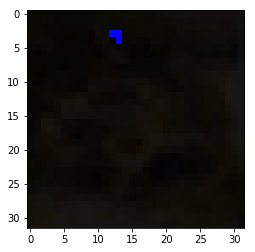

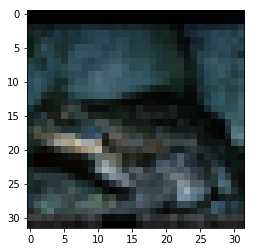

In [37]:
plt.imshow(plt.imread('./gan-logs/generated_frog6900.png'))
plt.show()
plt.imshow(plt.imread('./gan-logs/real_frog9900.png'))